(wrapping_jax_function)=
# How to wrap a JAX function for use in PyMC

:::{post} Mar 24, 2022
:tags: Aesara, hidden markov model (HMM)
:category: advanced, how to
:author: Ricardo Vieira
:::

In [1]:
import aesara
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

from aesara.graph import Apply, Op

In [2]:
RANDOM_SEED = 104109109
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

:::{include} ../extra_installs.md
:::

In [3]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import pymc.sampling_jax

from aesara.link.jax.dispatch import jax_funcify

/home/ricardo/miniconda3/envs/pymc-examples/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/home/ricardo/Documents/Projects/pymc/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Intro: Aesara and its backends

PyMC uses the [Aesara](https://aesara.readthedocs.io/en/latest/) library to create and manipulate probabilistic graphs. Aesara is backend-agnostic, meaning it can make use of functions written in different languages or frameworks, including pure Python, NumPy, C, Cython, Numba, and [JAX](https://jax.readthedocs.io/en/latest/index.html). 

All that is needed is to encapsulate such function in a Aeasara {class}`~aesara.graph.basic.Op`, which enforces a specific API regarding how inputs and outputs of pure "operations" should be handled. It also implement methods for optional extra functionality like symbolic shape inference and gradient expressions. This is well covered in the Aesara [`Op`s documentation](https://aesara.readthedocs.io/en/latest/extending/op.html) and in our {ref}`blackbox_external_likelihood_numpy` pymc-example.

More recentely, Aesara became capable of compiling directly to some of these languages/frameworks, meaning that we can convert a complete Aesara graph into a JAX or NUMBA jitted function, whereas traditionally they could only be converted to Python or C.

This has some interesting advantages, such as being able to sample models defined in PyMC using pure JAX samplers, such as those implemented in [NumPyro](https://num.pyro.ai/en/latest/index.html) or [BlackJax](https://github.com/blackjax-devs/blackjax). 

This notebook illustrates how we can implement a new Aesara {class}`~aesara.graph.basic.Op` that wraps a JAX function. 

### Outline

1. We start in a similar path as that taken in the {ref}`blackbox_external_likelihood_numpy`, which wraps a NumPy function in a Aesara {class}`~aesara.graph.basic.Op`, this time wrapping a JAX jitted function instead. 
2. We then enable Aesara to "unwrap" the just wrapped JAX function, so that the whole graph can be compiled to JAX. We make use of this to sample our PyMC model via the JAX NumPyro NUTS sampler.

# A motivating example: marginal HMM

For illustration purposes, we will simulate data following a simple [Hidden Markov Model](https://en.wikipedia.org/wiki/Hidden_Markov_model) (HMM), with 4 possible latent states $S \in \{0, 1, 2, 3\}$ and normal emission likelihood.

$$Y \sim \text{Normal}(S \cdot \text{signal}, (S + 1) \cdot \text{noise})$$

Our HMM will have a fixed Binomial probability of decaying from a higher state $S_t$ to a lower state $S_{t+1}$ in every step, 

$$S_{t+1} \sim \text{Binomial}(S_t, \text{1-p_decay})$$

This implies a zero probability of going from a lower state $S_{t}$ to a higher state $S_{t+1}$. 

To complete our model, we assume a fixed probability for each possible initial state $S_{t0}$,

$$S_{t0} \sim \text{Categorical}(P_{\{0, 1, 2, 3\}})$$


### Simulating data
Let's generate data according to this model! The first step is to set some values for the parameters in our model

In [4]:
# Emission signal and noise parameters
emission_signal_true = 0.75
emission_noise_true = 0.05

# Probability of starting in initial states [0, 1, 2, 3]
p_initial_state_true = np.array([0.01, 0.04, 0.25, 0.7])
assert np.isclose(np.sum(p_initial_state_true), 1)

p_decay_true = 0.125

In [5]:
# We will observe 100 HMM processes, each with a total of 50 steps
n_obs = 100
n_steps = 50

In [6]:
# Define Random Number Generator
rng_seed = int("".join(map(str, map(ord, "hmm"))))
rng = np.random.default_rng(rng_seed)

We write a helper function to generate a single HMM process and create our simulated data

In [7]:
def simulate_hmm(p_initial_state, p_decay, emission_signal, emission_noise, n_steps, rng):
    """Generate hidden state and emission from our HMM model."""
    n_possible_states = len(p_initial_state)
    initial_state = rng.choice(range(n_possible_states), p=p_initial_state)

    hidden_state = [initial_state]
    for step in range(n_steps):
        hidden_state.append(rng.binomial(n=hidden_state[-1], p=1 - p_decay))

    hidden_state = np.array(hidden_state)

    emission = rng.normal(
        hidden_state * emission_signal,
        (hidden_state + 1) * emission_noise,
    )

    return hidden_state, emission

In [8]:
single_hmm_hidden_state, single_hmm_emission = simulate_hmm(
    p_initial_state_true,
    p_decay_true,
    emission_signal_true,
    emission_noise_true,
    n_steps,
    rng,
)
print(single_hmm_hidden_state)
print(np.round(single_hmm_emission, 2))

[2 2 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 1.88  1.38  1.26  0.66  0.67  0.75 -0.05  0.06  0.04 -0.02 -0.04  0.05
  0.03 -0.03  0.18 -0.07 -0.04  0.09 -0.01 -0.   -0.01  0.02 -0.1  -0.03
 -0.02 -0.1  -0.03  0.05  0.01  0.03 -0.08 -0.08 -0.05 -0.04  0.05  0.03
  0.03  0.04  0.   -0.03 -0.02  0.05  0.09  0.06 -0.12 -0.03  0.03  0.06
 -0.06 -0.11  0.05]


In [9]:
hidden_state_true = []
emission_observed = []

for i in range(n_obs):
    hidden_state, emission = simulate_hmm(
        p_initial_state_true,
        p_decay_true,
        emission_signal_true,
        emission_noise_true,
        n_steps,
        rng,
    )
    hidden_state_true.append(hidden_state)
    emission_observed.append(emission)

hidden_state = np.array(hidden_state_true)
emission_observed = np.array(emission_observed)

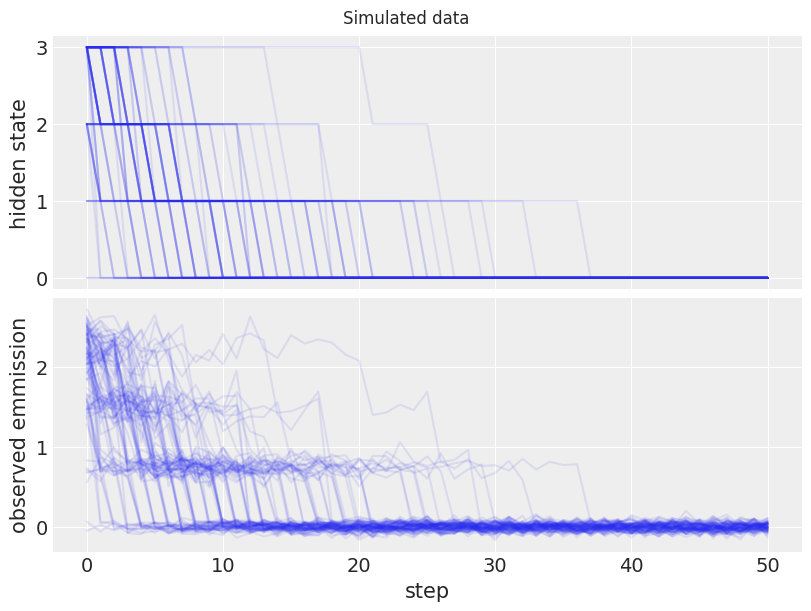

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
for hidden_state, emission in zip(hidden_state_true, emission_observed):
    ax[0].plot(hidden_state, color="C0", alpha=0.1)
    ax[1].plot(emission, color="C0", alpha=0.1)
ax[0].set_ylabel("hidden state")
ax[1].set_ylabel("observed emmission")
ax[1].set_xlabel("step")
fig.suptitle("Simulated data");

The figure above shown the hidden state and respective observed emission for our simulated data. We will use this data later to perform posterior inferences about the model parameters.

## Computing the marginal HMM likelihood using JAX

We will write a JAX function to compute the likelihood of hour HMM model, marginalizing over the hidden states. This allows for more efficient sampling of the remaining model parameters. To achieve this, we will use the well known [forward algorithm](https://en.wikipedia.org/wiki/Forward_algorithm), working on the log scale for numerical stability.

We will take advantage of JAX [scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) to obtain an efficient and differentiable log-likelihood, and the handy [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html#jax.vmap) to automatically vectorize this log-likelihood across multiple observed processes.

Before that, let us create some helper variables derived from our true parameters, that we can use to test our implementation

In [11]:
n_hidden_states = len(p_initial_state_true)
n_hidden_states

4

In [12]:
logp_initial_state_true = np.log(p_initial_state_true)
logp_initial_state_true

array([-4.60517019, -3.21887582, -1.38629436, -0.35667494])

In [13]:
# Compute the probability transition matrix, of going from S_t to S_t+1
# p[0, 0], is the probability of going from S_t=0 to S_t+1=0
# p[1, 0], is the probability of going from S_t=1 to S_t+1=0
# p[0, 1], is the probabilty of going from S_t=0 to S_t+1=1 (which is impossible)
# p[3, 3], is the probability of going from S_t=3, to S_t+1=3
possible_states = np.arange(n_hidden_states)
p_transition_true = (
    pm.logp(
        pm.Binomial.dist(n=possible_states, p=1 - p_decay_true),
        possible_states[..., None],
    )
    .T.exp()
    .eval()
)
p_transition_true

array([[1.        , 0.        , 0.        , 0.        ],
       [0.125     , 0.875     , 0.        , 0.        ],
       [0.015625  , 0.21875   , 0.765625  , 0.        ],
       [0.00195313, 0.04101563, 0.28710938, 0.66992188]])

In [14]:
# Confirm that we have a valid transition probability matrix
assert np.allclose(np.sum(p_transition_true, axis=-1), 1)

In [15]:
logp_transition_true = np.log(p_transition_true)
logp_transition_true

/tmp/ipykernel_50077/135191845.py:1: RuntimeWarning: divide by zero encountered in log
  logp_transition_true = np.log(p_transition_true)


array([[ 0.        ,        -inf,        -inf,        -inf],
       [-2.07944154, -0.13353139,        -inf,        -inf],
       [-4.15888308, -1.51982575, -0.26706279,        -inf],
       [-6.23832463, -3.19380219, -1.24789204, -0.40059418]])

### Writing the JAX function

This is our core JAX function which computes the marginal log-likelihood of a single HMM process

In [16]:
def hmm_logp(
    emission_observed,
    emission_signal,
    emission_noise,
    logp_initial_state,
    logp_transition,
):
    """Compute the marginal log-likelihood of a single HMM process."""

    # Caution: Using global variable for simplicity!
    hidden_states = np.arange(n_hidden_states)

    # Compute log-likelihood of observed emissions for each (step x possible hidden state)
    logp_emission = jsp.stats.norm.logpdf(
        emission_observed[:, None],
        hidden_states * emission_signal,
        (hidden_states + 1) * emission_noise,
    )

    # We use the forward_algorithm to compute log_alpha(x_t) = logp(x_t, y_1:t)
    log_alpha = logp_initial_state + logp_emission[0]
    log_alpha, _ = jax.lax.scan(
        f=lambda log_alpha_prev, logp_emission: (
            jsp.special.logsumexp(log_alpha_prev + logp_transition.T, axis=-1) + logp_emission,
            None,
        ),
        init=log_alpha,
        xs=logp_emission[1:],
    )

    return jsp.special.logsumexp(log_alpha)

Let's test it with the true parameters and the first simulated HMM proccess

In [17]:
hmm_logp(
    emission_observed[0],
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)

DeviceArray(64.4334196, dtype=float64)

We now use vmap to vectorize the core function across multiple observations.

In [18]:
def vec_hmm_logp(*args):
    vmap = jax.vmap(
        hmm_logp,
        # Only the first argument, needs to be vectorized
        in_axes=(0, None, None, None, None),
    )
    # For simplicity we sum across all the HMM processes
    return jnp.sum(vmap(*args))


# We jit it for better performance!
jitted_vec_hmm_logp = jax.jit(vec_hmm_logp)

Passing a row matrix with only the first simulated HMM process should return the same result

In [19]:
jitted_vec_hmm_logp(
    emission_observed[0][None, :],
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)

DeviceArray(64.4334196, dtype=float64)

Our goal is, however, to compute the joint log-likelihood for all the simulated data

In [20]:
jitted_vec_hmm_logp(
    emission_observed,
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)

DeviceArray(6201.29769409, dtype=float64)

Similarly to Aesara, it's pretty easy to get a graph for the gradients wrt to our inputs in JAX

In [21]:
jitted_vec_hmm_logp_grad = jax.jit(jax.grad(vec_hmm_logp, argnums=list(range(5))))

Let's print out the gradient with respect to `emission_signal`, and compare it with a rough finite difference computation

In [22]:
jitted_vec_hmm_logp_grad(
    emission_observed,
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)[1]

DeviceArray(33.41415676, dtype=float64, weak_type=True)

In [23]:
eps = 1e-5

grad1 = jitted_vec_hmm_logp(
    emission_observed,
    emission_signal_true + eps,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)

grad2 = jitted_vec_hmm_logp(
    emission_observed,
    emission_signal_true - eps,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)

(grad1 - grad2) / (2 * eps)

DeviceArray(33.41415741, dtype=float64)

Looks good!

# Wrapping the JAX function in Aesara

Now we are ready to wrap our JAX jitted function in a Aesaara {class}`~aesara.graph.basic.Op`, that we can use in our PyMC models later on. We recommend you check Aesara's official [`Op` documentation](https://aesara.readthedocs.io/en/latest/extending/op.html) if you want to undertand it in more detail.

In brief, we will inherit from {class}`~aesara.graph.basic.Op` and define the following methods:
1. `make_node`: Creates an {class}`~aesara.graph.basic.Apply` node that holds together the symbolic inputs and outputs of our operation
2. `perform`: Python code that returns the evaluation of our operation, given concrete input values
3. `grad`: Returns a Aesara symbolic graph that represents the gradient expression of an output cost wrt to its inputs

For the `grad` we will create a second {class}`~aesara.graph.basic.Op` that wraps our jitted grad version from above

In [24]:
class HMMLogpOp(Op):
    def make_node(self, *inputs):
        # Convert our inputs to symbolic variables
        inputs = [at.as_tensor_variable(inp) for inp in inputs]
        # Define the type of the output returned by the wrapped JAX function
        outputs = [at.fscalar()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        result = jitted_vec_hmm_logp(*inputs)
        # Aesara complains if the dtype of the returned output is not
        # exactly the one expected from the Apply node (in this case
        # `dscalar`, which stands for float64 scalar), so we make sure
        # to convert to the expected dtype. To avoid unecessary conversions
        # you should make sure the expected output defined in `make_node`
        # is already of the correct dtype
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

    def grad(self, inputs, output_gradients):
        gradients = hmm_logp_grad_op(*inputs)
        return [output_gradients[0] * gradient for gradient in gradients]


class HMMLogpGradOp(Op):
    def make_node(self, *inputs):
        inputs = [at.as_tensor_variable(inp) for inp in inputs]
        # This `Op` wil return one gradient per input. For simplicity, we assume
        # each output is of the same type as the input. In practice, you should use
        # the exact dtype to avoid overhead when saving the results of the computation
        # in `perform`
        outputs = [inp.type() for inp in inputs]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        # If there are inputs for which the gradients will never be needed or cannot
        # be computed, `aesara.gradient.grad_not_implemented` should  be used
        results = jitted_vec_hmm_logp_grad(*inputs)
        for i, result in enumerate(results):
            outputs[i][0] = np.asarray(result, dtype=node.outputs[i].dtype)


# Initialize our `Op`s
hmm_logp_op = HMMLogpOp()
hmm_logp_grad_op = HMMLogpGradOp()

We can use the debug helper `eval` method to confirm we get the same outputs as before

In [25]:
hmm_logp_op(
    emission_observed,
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
).eval()

array(6201.298, dtype=float32)

In [26]:
hmm_logp_grad_op(
    emission_observed,
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)[1].eval()

array(33.414154, dtype=float32)

It's also helpful to confirm that the gradient of our {class}`~aesara.graph.basic.Op` can be requested via the Aesara `grad` interface

In [27]:
# We define the symbolic `emission_signal` variable outside of the `Op`
# so that we can request the gradient wrt to it
emission_signal_variable = at.as_tensor_variable(emission_signal_true)
x = hmm_logp_op(
    emission_observed,
    emission_signal_variable,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)
x_grad_wrt_emission_signal = at.grad(x, wrt=emission_signal_variable)
x_grad_wrt_emission_signal.eval()

array(33.414154, dtype=float32)

## Sampling with PyMC

We are now ready to make inferences about our HMM model with PyMC. We will define priors for each model parameter and use {class}`~pymc.Potential` to add the joint log-likelihood term to our model.

In [28]:
with pm.Model(rng_seeder=int(rng.integers(2**30))) as model:
    emission_signal = pm.Normal("emission_signal", 0, 1)
    emission_noise = pm.HalfNormal("emission_noise", 1)

    p_initial_state = pm.Dirichlet("p_initial_state", np.ones(n_hidden_states))
    logp_initial_state = at.log(p_initial_state)

    p_decay = pm.Beta("p_decay", 1, 1)
    logp_transition = pm.logp(
        pm.Binomial.dist(n=possible_states, p=1 - p_decay), possible_states[:, None]
    ).T

    loglike = pm.Potential(
        "hmm_loglike",
        hmm_logp_op(
            emission_observed,
            emission_signal,
            emission_noise,
            logp_initial_state,
            logp_transition,
        ),
    )

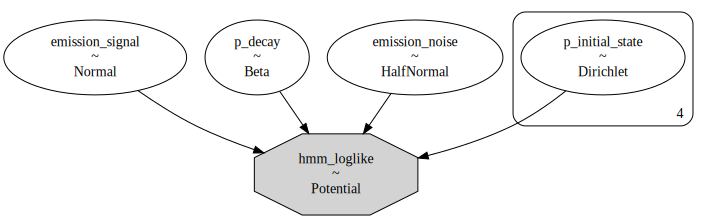

In [29]:
pm.model_to_graphviz(model)

Before we start sampling, we check the logp of each variable at the model initial point

In [30]:
initial_point = model.compute_initial_point()
initial_point

{'emission_signal': array(0.),
 'emission_noise_log__': array(0.),
 'p_initial_state_simplex__': array([0., 0., 0.]),
 'p_decay_logodds__': array(0.)}

In [31]:
model.point_logps(initial_point)

{'emission_signal': -0.92,
 'emission_noise': -0.73,
 'p_initial_state': -2.37,
 'p_decay': -1.39,
 'hmm_loglike': -5643.38}

We are now ready to sample!

In [32]:
with model:
    idata = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
/home/ricardo/Documents/Projects/pymc/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Sequential sampling (2 chains in 1 job)
INFO:pymc:Sequential sampling (2 chains in 1 job)
NUTS: [emission_signal, emission_noise, p_initial_state, p_decay]
INFO:pymc:NUTS: [emission_signal, emission_noise, p_initial_state, p_decay]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 168 seconds.
INFO:pymc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 168 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
INFO:pymc:We recommend running at least 4 chains for robust computation of convergence diagnostics


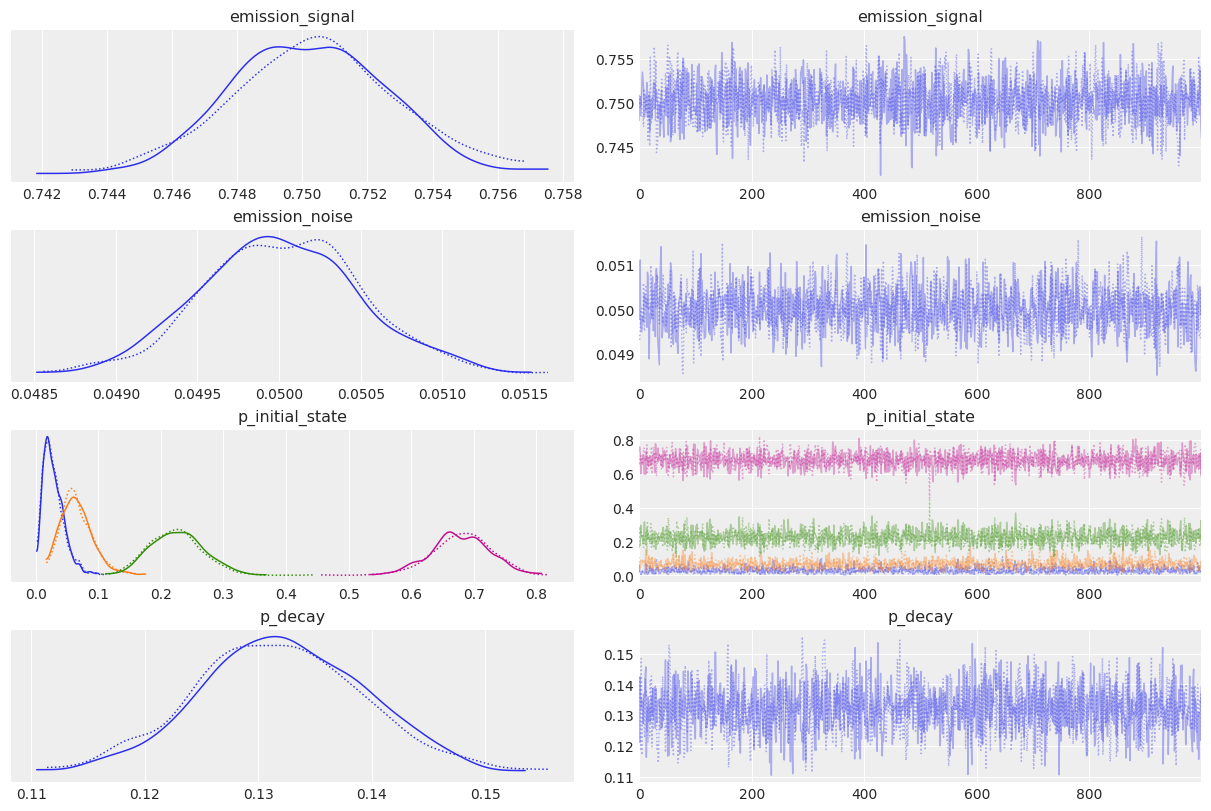

In [33]:
az.plot_trace(idata);

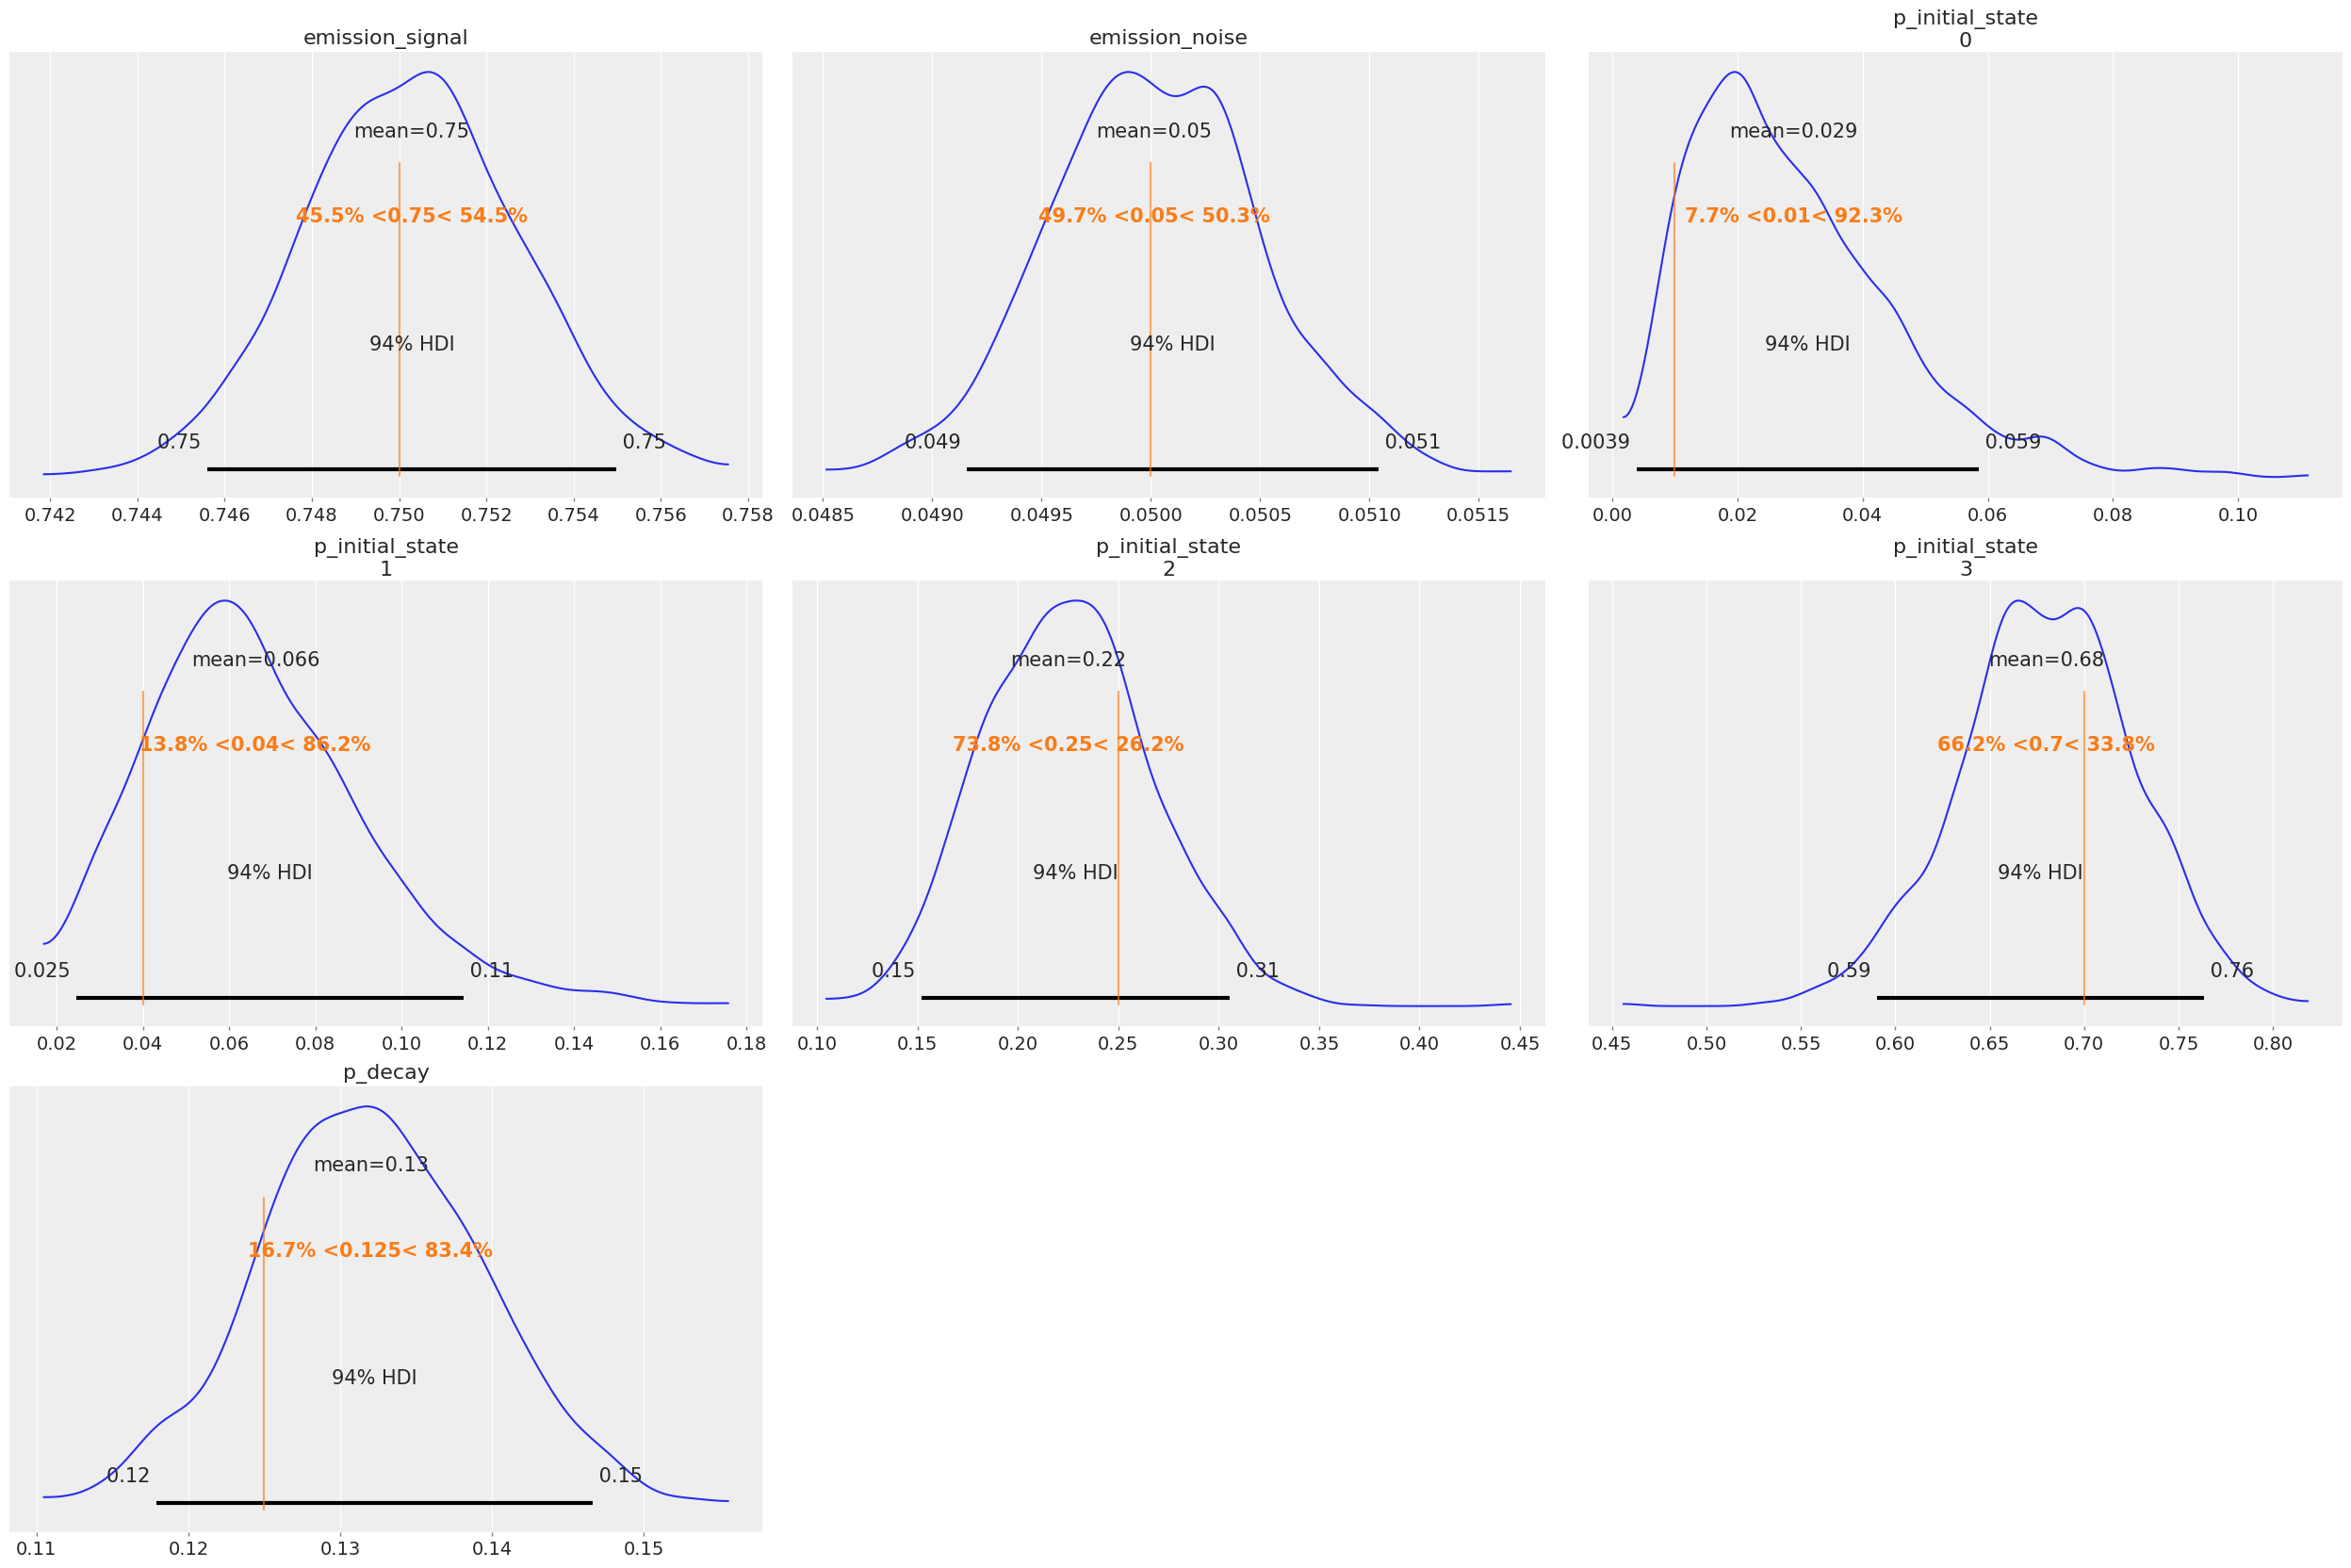

In [34]:
true_values = [
    emission_signal_true,
    emission_noise_true,
    *p_initial_state_true,
    p_decay_true,
]

az.plot_posterior(idata, ref_val=true_values);

The posteriors look reasonably centered around the true values used to generate our data.

# Unwrapping the wrapped JAX function

As mentioned in the beginning, Aesara can compile an entire graph to JAX. To do this, it needs to know how each {class}`~aesara.graph.basic.Op` in the graph can be converted to a JAX function. This can be done by {term}`dispatch <dispatching>` with {func}`aesara.link.jax.dispatch.jax_funcify`. Most of the default Aesara {class}`~aesara.graph.basic.Op`s already have such a dispatch function, but we will need to add a new one for our custom `HMMLogpOp`, as Aesara has never seen that before.

For that we need a function which returns (another) JAX function, that performs the same computation as in our `perform` method. Fortunately, because we started exactly with such function, this amounts to 3 short lines of code.

In [35]:
@jax_funcify.register(HMMLogpOp)
def hmm_logp_dispatch(op, **kwargs):
    return vec_hmm_logp

:::{note}
We do not return the jitted function, so that the entire Aesara graph can be jitted together after being converted to JAX.
:::

For a better understanding into {class}`~aesara.graph.basic.Op` JAX conversions, we recommend you check Aesara's [Adding JAX and Numba support for Ops guide](https://aesara.readthedocs.io/en/latest/extending/creating_a_numba_jax_op.html?highlight=JAX)

We can test that our conversion function is working properly by compiling a {func}`aesara.function` with `mode="JAX"`:

In [36]:
out = hmm_logp_op(
    emission_observed,
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)
jax_fn = aesara.function(inputs=[], outputs=out, mode="JAX")
jax_fn()

DeviceArray(6201.298, dtype=float32)

We can also compile a JAX function that computes the log probability of each variable in our PyMC model, similar to {meth}`~pymc.Model.point_logps`

In [37]:
inputs = model.value_vars
outputs = model.logpt(sum=False)
model_logp_jax_fn = aesara.function(inputs, outputs, mode="JAX")

In [38]:
model_logp_jax_fn(*initial_point.values())

[DeviceArray(-0.91893853, dtype=float64),
 DeviceArray(-0.72579135, dtype=float64),
 DeviceArray(-2.36712361, dtype=float64),
 DeviceArray(-1.38629436, dtype=float64),
 DeviceArray(-5643.37548438, dtype=float64)]

Note that we could have added an equally simple function to convert our `HMMLogpGradOp`, in case we wanted to convert Aesara gradient graphs to JAX. In our case, we don't need to do this because we will rely on JAX `grad` function (or more precisely, NumPyro will rely on it) to obtain these again from our compiled JAX function.

We include a {ref}`aesara_vs_jax <short discussion>` at the end of this document, to help you better understand the trade-offs between writting grahs in Aesara vs JAX, and when you migh want to use one or the other.

## Sampling with Numpyro

Now that we know our model logp can be entirely compiled to JAX, we can use the handy {mod}`pymc.sampling_jax` module to sample our model using the pure JAX sampler implemented in NumPyro.

In [39]:
with model:
    idata_numpyro = pm.sampling_jax.sample_numpyro_nuts(chains=2)

/home/ricardo/miniconda3/envs/pymc-examples/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ricardo/Documents/Projects/pymc/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


Compiling...
Compilation time =  0:00:01.977769
Sampling...


Running chain 1: 100%|██████████████████████| 2000/2000 [01:02<00:00, 31.78it/s]


Sampling time =  0:01:03.539740
Transforming variables...
Transformation time =  0:00:00.355642


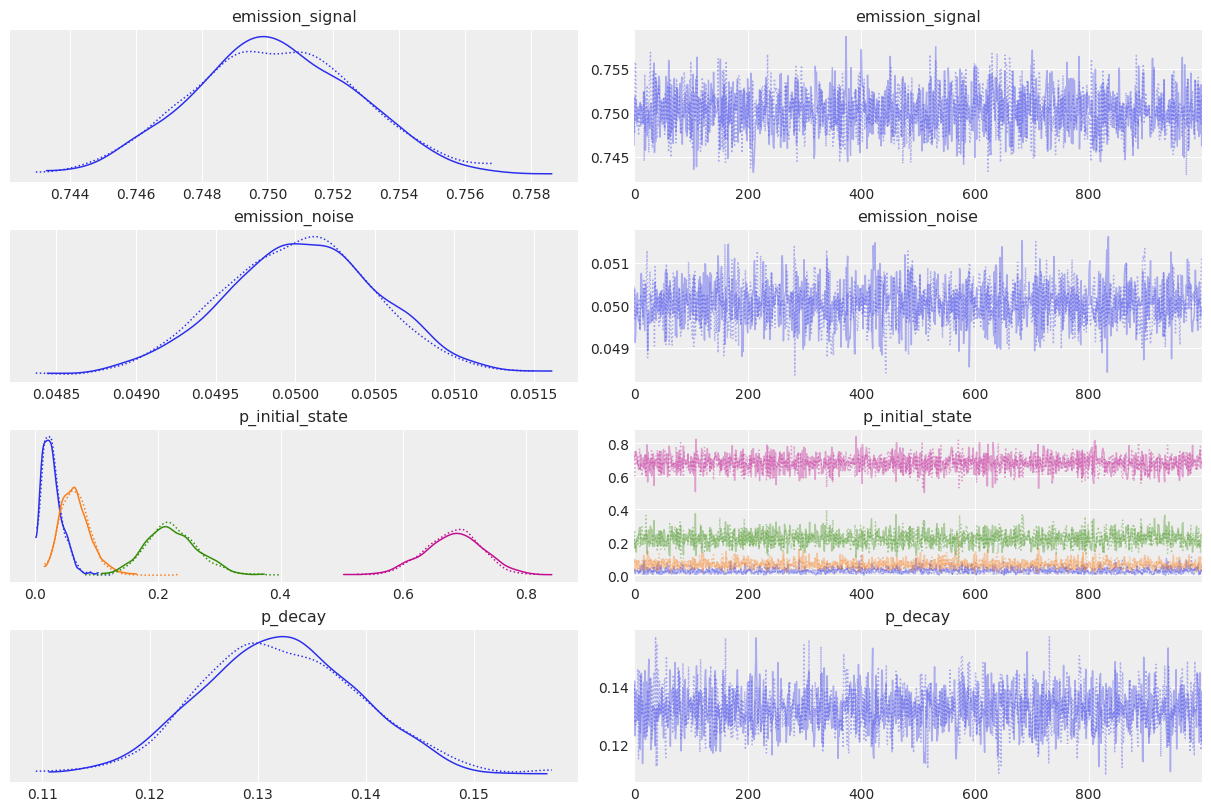

In [40]:
az.plot_trace(idata_numpyro);

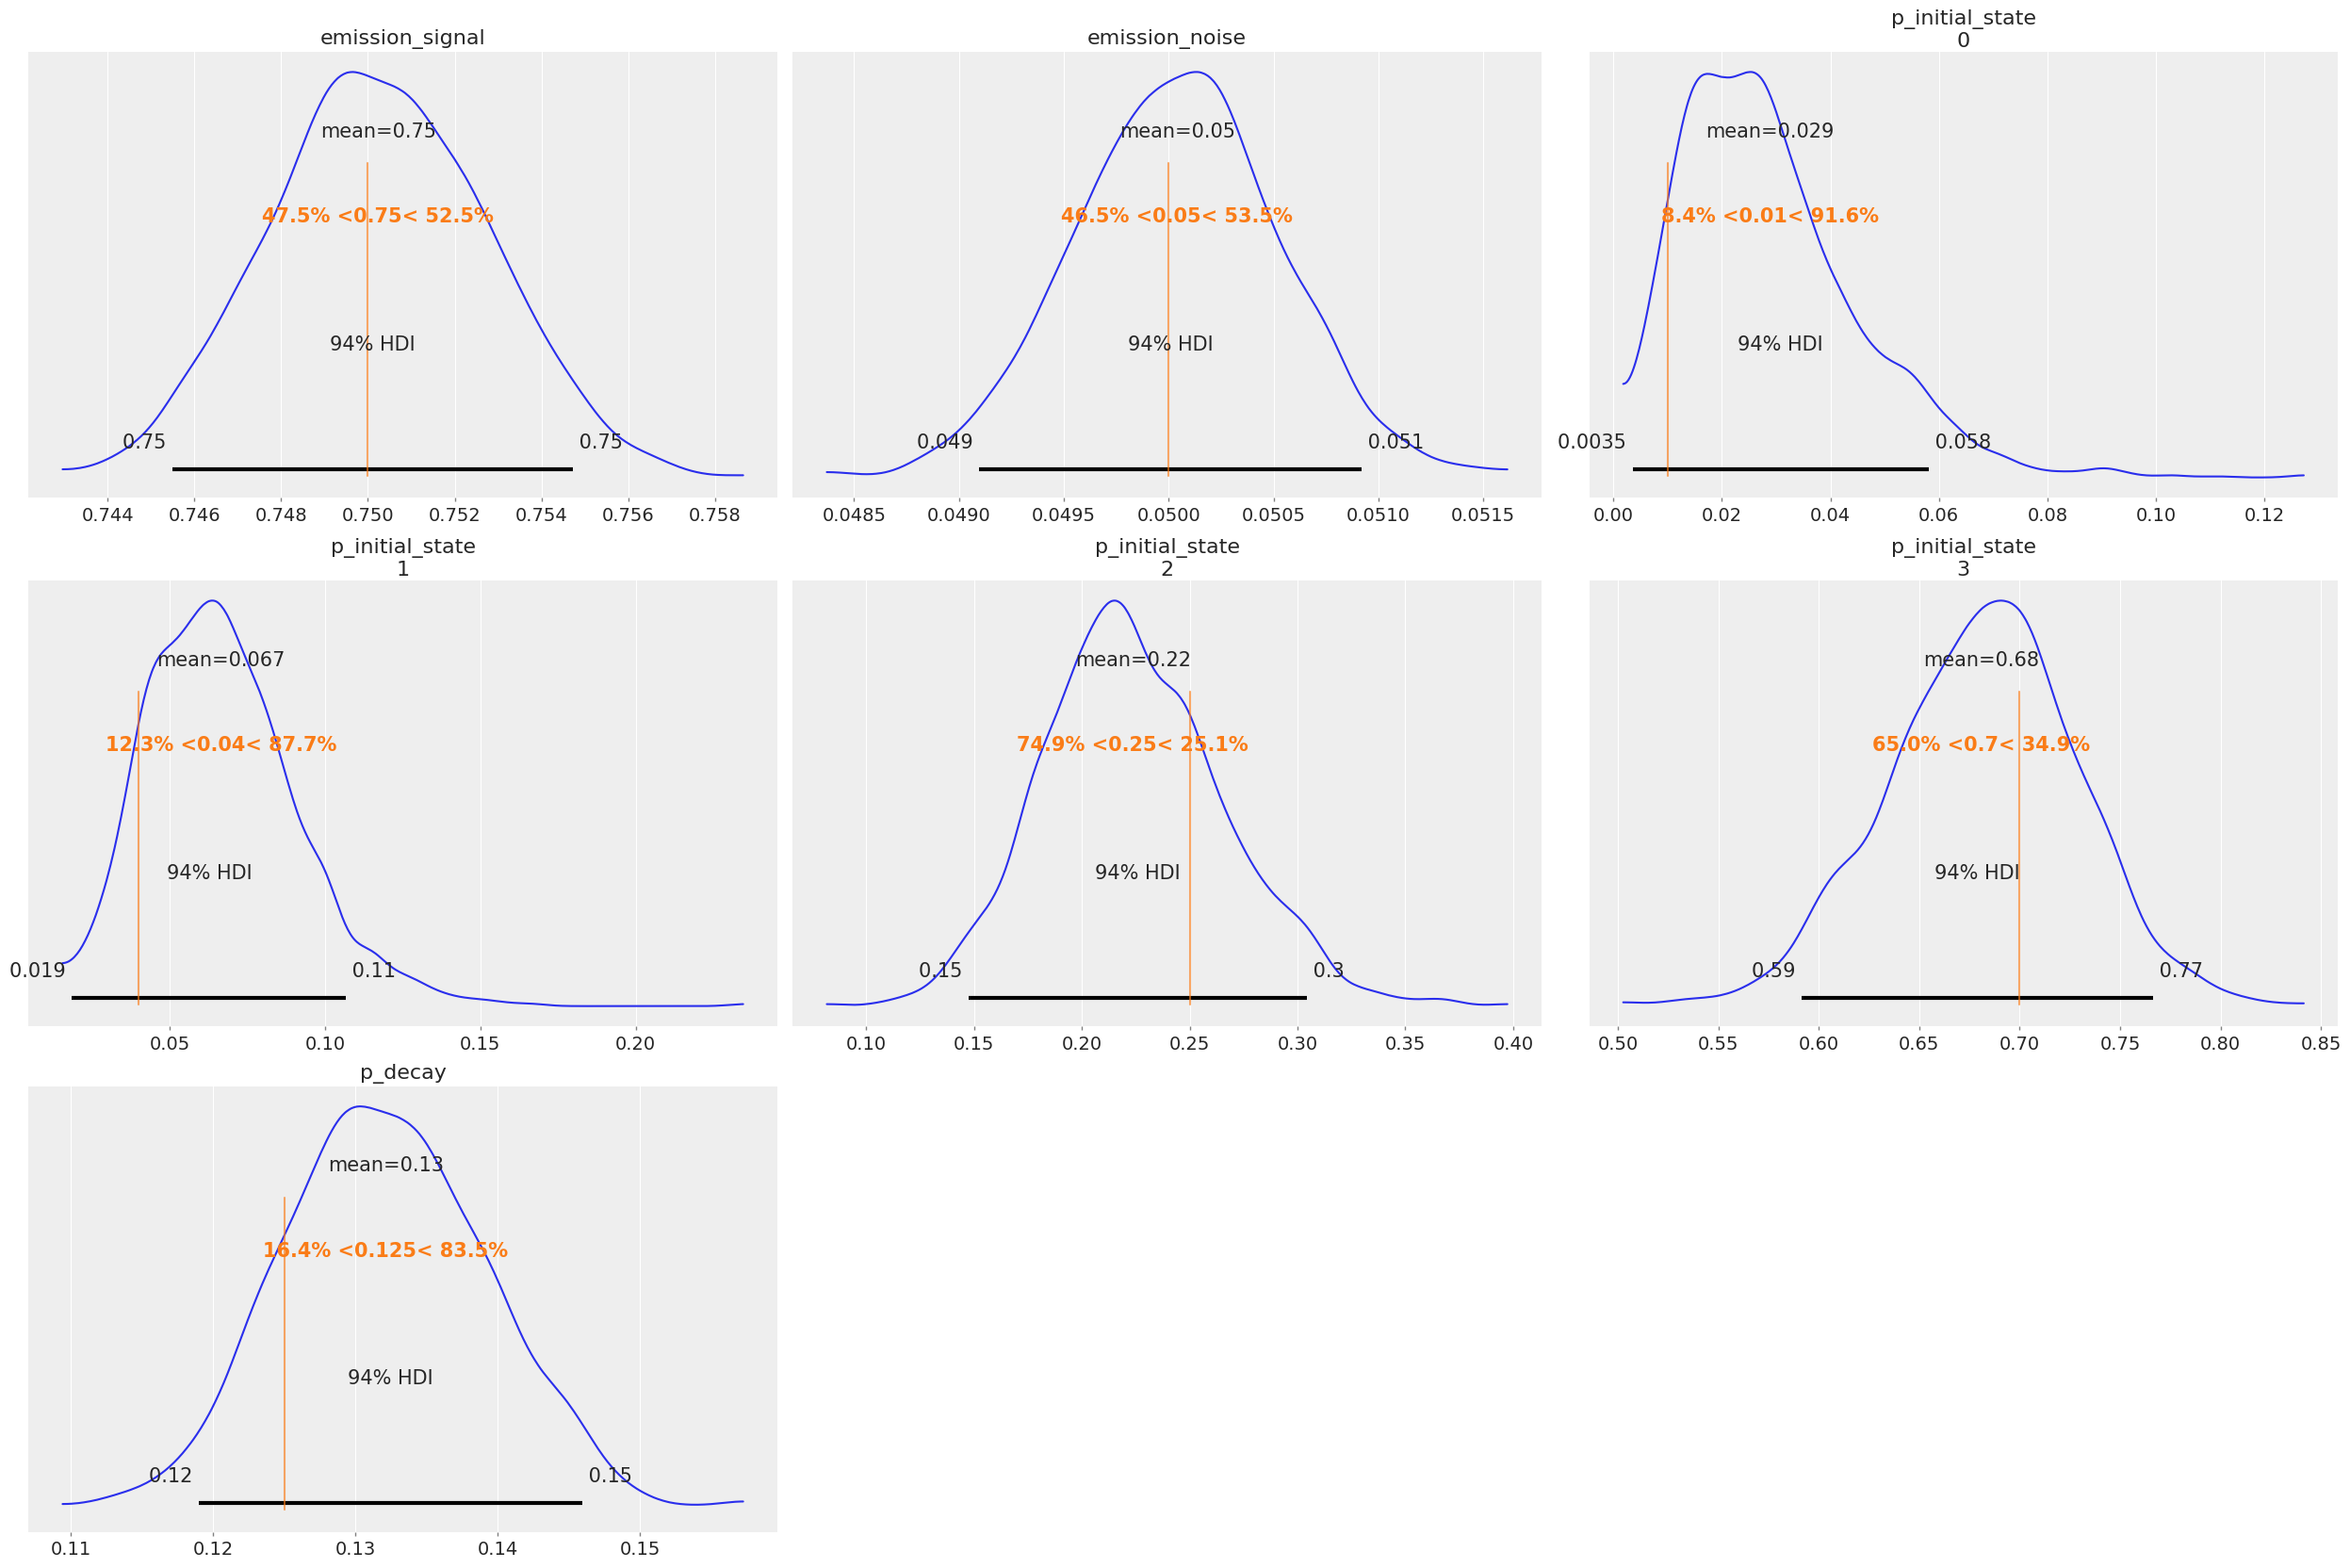

In [41]:
az.plot_posterior(idata_numpyro, ref_val=true_values);

As expected, sampling results look pretty similar! 

Depending on the model and computer architecture you are using, a pure JAX sampler can provide considerable speedups.

## Bonus: Using a single Op to wrap the value and gradients at once

We had to create two {class}`~aesara.graph.basic.Op`s, one for the function we cared about and a separate one for its gradients. However, JAX provides a `value_and_grad` utility that can return both the value of a function and its derivatives. This means we can get away with a single {class}`~aesara.graph.basic.Op` if we are clever about it.

It also means we can (potentially) save memory and reuse computation that is shared between the function and its gradients. This may be relevant when working with very large JAX functions.

Note that this is only useful if you are interested in taking gradients with respect to your {class}`~aesara.graph.basic.Op` using Aesara. If your endgoal is to compile your graph to JAX, and only then take derivatives (as NumPyro does), then it's better to use the first approach. You don't even need to implement the `grad` method and associated {class}`~aesara.graph.basic.Op` in that case.

In [42]:
jitted_hmm_logp_value_and_grad = jax.jit(jax.value_and_grad(vec_hmm_logp, argnums=list(range(5))))

In [43]:
class HmmLogpValueGradOp(Op):
    # By default only return the first output
    default_output = 0

    def make_node(self, *inputs):
        inputs = [at.as_tensor_variable(inp) for inp in inputs]
        # We now have one output for the function value, and one output for each gradient
        outputs = [at.dscalar()] + [inp.type() for inp in inputs]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        result, grad_results = jitted_hmm_logp_value_and_grad(*inputs)
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)
        for i, grad_result in enumerate(grad_results, start=1):
            outputs[i][0] = np.asarray(grad_result, dtype=node.outputs[i].dtype)

    def grad(self, inputs, output_gradients):
        # The `Op` computes its own gradients, so we call it again.
        value = self(*inputs)
        # We hid the gradient outputs by setting `default_update=0`, but we
        # can retrieve them anytime by accessing the `Apply` node via `value.owner`
        gradients = value.owner.outputs[1:]

        # Make sure the user is not trying to take the gradient with respect to
        # the gradient outputs! That would require computing the second order
        # derivatives
        assert all(
            isinstance(g.type, aesara.gradient.DisconnectedType) for g in output_gradients[1:]
        )

        return [output_gradients[0] * grad for grad in gradients]


hmm_logp_value_grad_op = HmmLogpValueGradOp()

We check again that we can take the gradient using Aesara `grad` interface

In [44]:
emission_signal_variable = at.as_tensor_variable(emission_signal_true)
# Only the first output is assigned to the variable `x`, due to `default_output=0`
x = hmm_logp_value_grad_op(
    emission_observed,
    emission_signal_variable,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)
at.grad(x, emission_signal_variable).eval()

array(33.41415405)

(aesara_vs_jax)=
## Notes on using Aesara vs JAX

### When should you write functions in JAX?

As we have seen, it is pretty straightforward to interface between Aesara graphs and JAX functions. 

This can be very handy when you want to combine previously implemented JAX function with PyMC models. We used a marginalized HMM log-likelihood in this example, but the same strategy could be used to do Bayesian inference with Deep Neural Networks or Differential Equations, or pretty much any other functions implemented in JAX that can be used in the context of a Bayesian model.

It can also be important, if you need to make use of JAX's unique features like vectorization, support for tree structures, or make use of its fine-grained parallelization, or GPU and TPU capabilities.

### When should you not write functions in JAX?

Like JAX, Aesara has the goal of mimicking the NumPy and Scipy APIs, so that writting code in Aesara should feel very similar to how code is written in those libraries.

There are, however, some of advantages to working with Aesara:

1. Aesara graphs are considerably easier to [inspect and debug](https://aesara.readthedocs.io/en/latest/tutorial/debug_faq.html) than JAX functions
2. Aesara has clever [optimization and stabilization routines](https://aesara.readthedocs.io/en/latest/optimizations.html) that are not possible or implemented in JAX
3. Aesara graphs can be easily [manipulated after creation](https://aesara.readthedocs.io/en/latest/extending/graph_rewriting.html#graph-rewriting)

Point 2 means your graphs are likely to perform better if written in Aesara. In general you don't have to worry about using specialized functions like `log1p` or `logsumexp`, as Aesara will be able to detect the equivalent naive expressions and replace them by their specialized counterparts. Importantly, you still benefit from these optimizations when your graph is later compiled to JAX.

The catch is that Aesara cannot reason about JAX functions, and by association {class}`~aesara.graph.basic.Op`s that wrap them. This means that the larger the portion of the graph is "hidden" inside a JAX function, the less a user will benefit from Aesara's rewrite and debugging abilities.

Point 3 is more important for library developers. It is the main reason why PyMC developers opted to use Aesara (and before that, its predecessor Theano) as its backend. Many of the user-facing utilities provided by PyMC rely on the ability to easily parse and manipulate Aesara graphs.

## Authors

Authored by [Ricardo Vieira](https://github.com/ricardoV94/) in March 24, 2022 ([pymc-examples#302](https://github.com/pymc-devs/pymc-examples/pull/302))

## Watermark

In [45]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Thu Mar 24 2022

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.1.1

aesara: 2.5.1
aeppl : 0.0.27
xarray: 2022.3.0

numpy     : 1.22.3
matplotlib: 3.5.1
pymc      : 4.0.0b5
arviz     : 0.12.0
aesara    : 2.5.1
jax       : 0.3.4

Watermark: 2.3.0



:::{include} ../page_footer.md
:::